In [1]:
import torch
import glob
import os
from PIL import Image
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.preprocessing import normalize
import keras
from keras.utils import normalize, to_categorical
from sklearn.preprocessing import LabelEncoder
import segmentation_models as sm
from torch.utils.data import DataLoader
import albumentations as album

Segmentation Models: using `keras` framework.


In [2]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, test = False):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','*.png'))
        self.mask_files = []
        self.img = []
        self.mask = []
        self.test = test
        
        if not self.test:
            for img_path in self.img_files:
                self.mask_files.append(os.path.join(folder_path,'labels',os.path.basename(img_path.split(".")[0] + "_Annotation.png"))) 
        

    def __getall__(self):
        for each in self.img_files:
            self.img.append(normalize(cv2.resize(cv2.imread(each, cv2.IMREAD_COLOR), (512,512)), axis = 1))
        if not self.test:
            for each in self.mask_files:
                self.mask.append(cv2.resize(cv2.imread(each, 0), (512,512)))
            return (np.array(self.img)) , (np.array(self.mask))
        else:
            return (np.array(self.img))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_COLOR)
            label = cv2.imread(mask_path, 0)
            label = to_categorical(label, 6)
            return torch.from_numpy(data).float().permute(2,0,1), torch.from_numpy(label).float().permute(2,0,1)

    def __len__(self):
        return len(self.img_files)

In [3]:
train_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\train")
val_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\val")
test_dataset = DataLoaderSegmentation(r"C:\\College\\Origin Health\\origin_health_role_challenge_dataset\\interview\\test", test = True)

torch.Size([3, 540, 800]) torch.Size([6, 540, 800])
torch.Size([540, 800, 3])


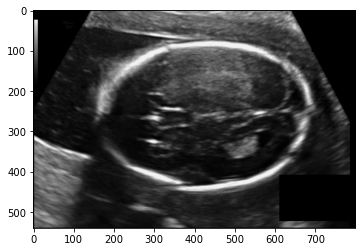

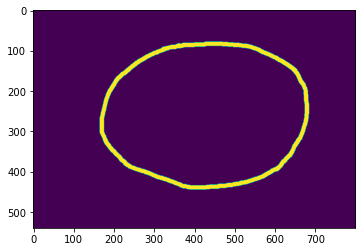

In [4]:
image, mask = train_dataset.__getitem__(5)
print(image.shape, mask.shape)
print(image.permute(1, 2, 0).shape)
plt.imshow(image.permute(1, 2, 0)/255)
plt.show()
plt.imshow(mask[1]/255)
plt.show()

In [5]:
train_images, train_masks = train_dataset.__getall__()
val_images, val_masks = val_dataset.__getall__()
test_images = test_dataset.__getall__()

In [6]:
print(train_images.shape, train_masks.shape)
print(val_images.shape, val_masks.shape)
print(test_images.shape)

(59, 512, 512, 3) (59, 512, 512)
(10, 512, 512, 3) (10, 512, 512)
(13, 512, 512, 3)


In [7]:
print(np.unique(train_masks))

[0 1 2 3 4 5]


In [8]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)

C:\Users\prith\anaconda3\envs\fetal-segmentation\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Class weights are...: [ 0.27363086  3.49018015 19.8645973  28.50893433 16.00420529  0.52328018]


In [10]:
train_masks_cat = (to_categorical(train_masks, num_classes = 6))
val_masks_cat = (to_categorical(val_masks, num_classes = 6))
print(train_masks_cat.shape)
print(val_masks_cat.shape)

(59, 512, 512, 6)
(10, 512, 512, 6)


In [11]:
# train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
# val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

In [12]:
# def expanddims_n_tocategorical(x):
#     #x = x.unsqueeze(1)
#     x = torch.from_numpy(to_categorical(x.detach().numpy(), num_classes= 6))
#     return x.permute(0,3,1,2)

In [13]:
# images, labels = next(iter(train_dataloader))
# #labels = expanddims_n_tocategorical(labels)
# print(images.shape, labels.shape)
# #print(images[0].permute(1,2,0).shape)
# plt.imshow(images[0].permute(1,2,0)/255)
# plt.show()
# plt.imshow(labels[0][1]/255)
# plt.show()

# Model

In [14]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

# Setup

In [16]:
import tensorflow as tf
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [17]:
IMG_HEIGHT = train_images.shape[1]
IMG_WIDTH  = train_images.shape[2]
IMG_CHANNELS = train_images.shape[3]
n_classes = 6
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')


512 512 3
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
_____________________________________________________________________________

In [18]:
history = model.fit(train_images, 
                    train_masks_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(val_images, val_masks_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
model.save("unet_on_graysacle.hdf5")

Epoch 1/50
4/4 [==============================] - 32s 8s/step - loss: 1.8149 - accuracy: 0.4239 - val_loss: 1.4501 - val_accuracy: 0.5458
Epoch 2/50
4/4 [==============================] - 31s 8s/step - loss: 1.4927 - accuracy: 0.5002 - val_loss: 1.6339 - val_accuracy: 0.4226
Epoch 3/50
4/4 [==============================] - 30s 8s/step - loss: 1.4996 - accuracy: 0.4384 - val_loss: 1.3231 - val_accuracy: 0.3712
Epoch 4/50
4/4 [==============================] - 30s 8s/step - loss: 1.2309 - accuracy: 0.4266 - val_loss: 1.1754 - val_accuracy: 0.4964
Epoch 5/50
4/4 [==============================] - 30s 8s/step - loss: 1.0860 - accuracy: 0.5366 - val_loss: 1.0584 - val_accuracy: 0.5970
Epoch 6/50
4/4 [==============================] - 30s 8s/step - loss: 1.0095 - accuracy: 0.5953 - val_loss: 0.9859 - val_accuracy: 0.6058
Epoch 7/50
4/4 [==============================] - 30s 8s/step - loss: 0.9585 - accuracy: 0.6065 - val_loss: 0.9754 - val_accuracy: 0.6063
Epoch 8/50
4/4 [==================

In [20]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average

For A and B 0.32583814653407167


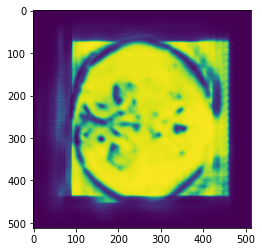

In [27]:
y_pred=model.predict(val_images)
plt.imshow(y_pred[0,:,:,0])
dice_score = dice_coef_multilabel(val_masks_cat, y_pred, 6)
print(f'For A and B {dice_score}')

In [19]:
y_pred=model.predict(val_images)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(val_masks_cat[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.011042592
[[  27060.   83090.       0.       0.       0.  921880.]
 [1219357.   35304.       0.       0.       0.  334749.]
 [      0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.]]
IoU for class1 is:  0.020353409196040336
IoU for class2 is:  0.026390561472202225
IoU for class3 is:  nan
IoU for class4 is:  nan


C:\Users\prith\AppData\Local\Temp\ipykernel_28480\3744536669.py:19: RuntimeWarning: invalid value encountered in double_scalars
  class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
C:\Users\prith\AppData\Local\Temp\ipykernel_28480\3744536669.py:20: RuntimeWarning: invalid value encountered in double_scalars
  class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])


Other varirants

In [15]:
n_classes=6
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights = class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [29]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(train_images)
X_val = preprocess_input1(val_images)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

#model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model1.summary())


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

In [30]:
history1=model1.fit(X_train1, 
          train_masks_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_val, val_masks_cat))

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

In [ ]:
model1.save("unet_with_resnet_backbone.hdf5")